# Deliverable 1 - Binary Classifier

## Import

In [1]:
# Disable Tensorflow's warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pathlib
from typing import Any,Union   

## Global Variables

In [3]:
BATCH_SIZE:int  = 64
IMG_HEIGHT:int  = 256
IMG_WIDTH:int   = 256
EPOCHS = 20

## Load Thomas Dataset

In [4]:
# Train
train_data = tf.keras.utils.image_dataset_from_directory('data/1_data_bin_thomas/train',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Validation
val_data = tf.keras.utils.image_dataset_from_directory('data/1_data_bin_thomas/val',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Evaluation
test_data = tf.keras.utils.image_dataset_from_directory('data/1_data_bin_thomas/test',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Get class names form dataset 
class_names = train_data.class_names

Found 22440 files belonging to 2 classes.
Found 4057 files belonging to 2 classes.
Found 4064 files belonging to 2 classes.


In [5]:
# Load datasets in cache to optimize training time
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Model

In [6]:
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
        # Rescaling (rescale pixel values between 0 and 1)
        tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Convolution Layers (feature extraction)
        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        # Deep Neural Network Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Output Layer (Binary model: 1 neurone and sigmoid activation)
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    # Compile model
    model.compile(optimizer='adamax',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

## Checkpoint

In [7]:
# Checkpoint callback to save the best weights during training
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/checkpoint/bin',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Train

In [8]:
# Train the model
with tf.device('/GPU:0'):
    history:tf.keras.callbacks.History = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        # Call to the checkpoint callback
        callbacks=model_checkpoint_callback
    )

Epoch 1/20
339/351 [===========================>..] - ETA: 1s - loss: 0.4562 - accuracy: 0.7541

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


351/351 [==============================] - 68s 181ms/step - loss: 0.4525 - accuracy: 0.7568 - val_loss: 0.3325 - val_accuracy: 0.8326
Epoch 2/20
351/351 [==============================] - 58s 165ms/step - loss: 0.3404 - accuracy: 0.8379 - val_loss: 0.2782 - val_accuracy: 0.8669
Epoch 3/20
351/351 [==============================] - 52s 147ms/step - loss: 0.2986 - accuracy: 0.8676 - val_loss: 0.2517 - val_accuracy: 0.8869
Epoch 4/20
351/351 [==============================] - 55s 156ms/step - loss: 0.2649 - accuracy: 0.8860 - val_loss: 0.2450 - val_accuracy: 0.8933
Epoch 5/20
351/351 [==============================] - 53s 151ms/step - loss: 0.2350 - accuracy: 0.9000 - val_loss: 0.2356 - val_accuracy: 0.9034
Epoch 6/20
351/351 [==============================] - 54s 155ms/step - loss: 0.2124 - accuracy: 0.9146 - val_loss: 0.2376 - val_accuracy: 0.9026
Epoch 7/20
351/351 [==============================] - 56s 160ms/step - loss: 0.1821 - accuracy: 0.9276 - val_loss: 0.3105 - val_accuracy: 0.8

## Graphs of the evolution of accuracy and loss 

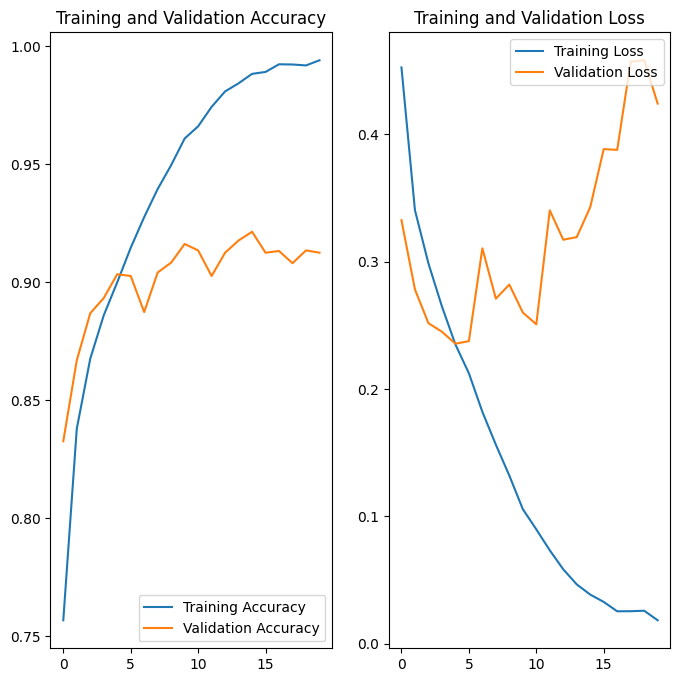

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate

In [10]:
# Load best weights (checkpoint)
model.load_weights('/tmp/checkpoint/bin')

In [11]:
# Evaluate the model with test dataset
results = model.evaluate(test_data, batch_size=64)
print("test loss, test acc:", results)

64/64 [==============================] - 21s 263ms/step - loss: 0.3240 - accuracy: 0.9252
test loss, test acc: [0.3240278959274292, 0.9251968264579773]


## Save

In [12]:
import datetime
import pandas as pd

date:datetime = datetime.datetime.now().strftime("%m.%d.%Y_%H:%M:%S")
model_dir:str = f"models/bin_{date}_{results[1]:.2f}%"
model.save(model_dir)
f = open(f"{model_dir}/model_summary.txt", "a")
model.summary(print_fn=lambda x: f.write(x + '\n'))
f.close()

f = open(f"{model_dir}/model_history.csv", "a")
f.write(pd.DataFrame.from_dict(history.history).to_csv(index=False))
f.close()

INFO:tensorflow:Assets written to: models/bin_10.20.2022_16:51:18_0.93%/assets


INFO:tensorflow:Assets written to: models/bin_10.20.2022_16:51:18_0.93%/assets
